# Прогнозирование показателя результативности обучения на курсах

**Исходные данные:** выборки, содержащие показатели прохождения курса обучающимися.
* 20241125_all_course.csv - общий датасет с данными учеников 3, 49, 71 и 77 учебных групп.

**Задача:** используя модели машинного обучения, спрогнозировать вероятность успешного прохождения курса.

## Ход решения задачи

## 1. Загрузка и предобработка данных

In [1]:
# Импорт библиотек для работы с данными
import pandas as pd
import numpy as np

# Импорт метрики MAE
from sklearn.metrics import mean_absolute_error

# импорт инструментов визуализации
import matplotlib.pyplot as plt
import seaborn as sns
# from phik.report import plot_correlation_matrix

#### 1.1 Загрузка данных

In [2]:
df = pd.read_csv('./original_dataset/20241125_all_course.csv')
df

,user_id,course_id,required_activities_delay_1_week,required_activities_delay_2_week,required_activities_delay_3_week,required_activities_delay_4_week,required_activities_delay_5_week,required_activities_delay_6_week,required_activities_delay_7_week,required_activities_delay_8_week,...,current_progress_4_week,current_progress_5_week,current_progress_6_week,current_progress_7_week,current_progress_8_week,current_progress_9_week,current_progress_10_week,end_status,m2_progress,m2_success
0,2614,77,4,1,4,4,0,1,0,1,...,38,50,55,77,88,100,100,2,100,1
1,6766,3,4,22,54,100,156,216,290,378,...,0,0,0,0,0,0,0,0,0,0
2,7722,3,4,22,54,100,156,216,290,378,...,0,0,0,0,0,0,0,0,0,0
3,10159,3,4,22,54,100,156,216,290,378,...,0,0,0,0,0,0,0,0,0,0
4,14558,71,4,22,54,100,156,216,290,378,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4986,199902148,77,10,35,74,127,190,257,344,452,...,0,0,0,0,0,0,0,0,0,0
4987,199902169,3,4,22,54,100,156,216,290,378,...,0,0,0,0,0,0,0,0,0,0
4988,199902704,3,4,4,1,4,0,4,14,39,...,37,50,50,56,56,77,81,2,75,0
4989,199903226,49,0,4,0,0,0,0,2,0,...,50,55,55,66,88,94,100,2,100,1


In [4]:
# df[df['course_id'] == 77].count()

In [3]:
import pandas as pd

# Шаг 1: Выбор 350 записей из группы course_id=77 и масштабирование до 1500
group_77_sample = df[df['course_id'] == 77].sample(n=350, replace=True)
group_77_expanded = group_77_sample.sample(n=1500, replace=True)

# Шаг 2: Выбор 1000 записей из групп course_id=3 и course_id=71 и масштабирование до 1500
group_3_sample = df[df['course_id'] == 3].sample(n=1000, replace=True)
group_71_sample = df[df['course_id'] == 71].sample(n=1000, replace=True)

# Масштабируем до 1500
group_3_expanded = group_3_sample.sample(n=1500, replace=True)
group_71_expanded = group_71_sample.sample(n=1500, replace=True)

# Шаг 3: Выбор 1500 записей из группы course_id=49 без масштабирования
group_49_sample = df[df['course_id'] == 49].sample(n=1500, replace=True)

# Объединение всех выборок
train_sample = pd.concat([group_77_expanded, group_3_expanded, group_71_expanded, group_49_sample])

# Проверка результата
print("\nРазмер итоговой выборки:", len(train_sample))
print("\nКоличество записей из course_id=49:", len(train_sample[train_sample['course_id'] == 49]))
print("\nКоличество записей из course_id=3:", len(train_sample[train_sample['course_id'] == 3]))
print("\nКоличество записей из course_id=77:", len(train_sample[train_sample['course_id'] == 77]))
print("\nКоличество записей из course_id=71:", len(train_sample[train_sample['course_id'] == 71]))


Размер итоговой выборки: 6000

Количество записей из course_id=49: 1500

Количество записей из course_id=3: 1500

Количество записей из course_id=77: 1500

Количество записей из course_id=71: 1500


In [4]:
# Создаем валидационную выборку методом исключения из датасета обучающих примеров
val_sample = df.drop(train_sample.index)

# Проверка результатов
print("Обучающая стратифицированная выборка:")
print(len(train_sample))
print("\nВалидационная выборка:")
print(len(val_sample))

Обучающая стратифицированная выборка:
6000

Валидационная выборка:
2538


#### 1.2. Предварительный анализ данных

In [7]:
# Проверяем на пропуски
# val_sample.isna().sum()

**Выводы:**
* в датасете нет пропусков, он хорошо подходит для обучения моделей;
* для прогнозирования целевого признака m2_progress в различные периоды необходимо сформировать датасеты для каждой недели, что позволит исключить "подглядывание в будущее".

#### 1.3. Создание отдельных датасетов для каждой недели

In [5]:
# Создаем датафрейм train_week_10

train_week_10 = train_sample.drop(['end_status', 'm2_progress'], axis=1)

# Создаем train_week_9
train_week_9 = train_week_10.copy()
train_week_9['required_activities_delay_10_week'] = 0
train_week_9['success_required_done_10_week'] = 0
train_week_9['mean_result_required_10_week'] = 0
train_week_9['cur_date_progress_10_week'] = 0
train_week_9['current_progress_10_week'] = 0

# Создаем train_week_8
train_week_8 = train_week_9.copy()
train_week_8['required_activities_delay_9_week'] = 0
train_week_8['success_required_done_9_week'] = 0
train_week_8['mean_result_required_9_week'] = 0
train_week_8['cur_date_progress_9_week'] = 0
train_week_8['current_progress_9_week'] = 0

# Создаем train_week_7
train_week_7 = train_week_8.copy()
train_week_7['required_activities_delay_8_week'] = 0
train_week_7['success_required_done_8_week'] = 0
train_week_7['mean_result_required_8_week'] = 0
train_week_7['cur_date_progress_8_week'] = 0
train_week_7['current_progress_8_week'] = 0

# Создаем train_week_6
train_week_6 = train_week_7.copy()
train_week_6['required_activities_delay_7_week'] = 0
train_week_6['success_required_done_7_week'] = 0
train_week_6['mean_result_required_7_week'] = 0
train_week_6['cur_date_progress_7_week'] = 0
train_week_6['current_progress_7_week'] = 0

# Создаем train_week_5
train_week_5 = train_week_6.copy()
train_week_5['required_activities_delay_6_week'] = 0
train_week_5['success_required_done_6_week'] = 0
train_week_5['mean_result_required_6_week'] = 0
train_week_5['cur_date_progress_6_week'] = 0
train_week_5['current_progress_6_week'] = 0

# Создаем train_week_4
train_week_4 = train_week_5.copy()
train_week_4['required_activities_delay_5_week'] = 0
train_week_4['success_required_done_5_week'] = 0
train_week_4['mean_result_required_5_week'] = 0
train_week_4['cur_date_progress_5_week'] = 0
train_week_4['current_progress_5_week'] = 0

# Создаем train_week_3
train_week_3 = train_week_4.copy()
train_week_3 ['required_activities_delay_4_week']= 0 
train_week_3 ['success_required_done_4_week']= 0 
train_week_3 ['mean_result_required_4_week']= 0 
train_week_3 ['cur_date_progress_4_week']= 0 
train_week_3 ['current_progress_4_week']= 0 

# Создаем train_week_2
train_week_2 = train_week_3.copy()
train_week_2 ['required_activities_delay_3_week']= 0 
train_week_2 ['success_required_done_3_week']= 0 
train_week_2 ['mean_result_required_3_week']= 0 
train_week_2 ['cur_date_progress_3_week']= 0 
train_week_2 ['current_progress_3_week']= 0 

# Создаем train_week_1
train_week_1 = train_week_2.copy()
train_week_1 ['required_activities_delay_2_week']= 0 
train_week_1 ['success_required_done_2_week']= 0 
train_week_1 ['mean_result_required_2_week']= 0 
train_week_1 ['cur_date_progress_2_week']= 0 
train_week_1 ['current_progress_2_week']= 0

In [9]:
# # оптимизируем предыдущий код:

# # Создаем датафрейм train_week_10
# train_week_10 = train_sample.drop(['end_status'], axis=1)

# # Инициализируем текущий датафрейм
# current_df = train_week_10

# # Создаём 9 дополнительных недельных датафреймов, начиная с train_week_9 и заканчивая train_week_1
# train_dataframes = {'train_week_10': train_week_10}

# for week in range(9, 0, -1):
#     next_df = current_df.copy()
    
#     # Добавляем новые столбцы для текущей недели
#     next_df[f'required_activities_delay_{week+1}_week'] = 0
#     next_df[f'success_required_done_{week+1}_week'] = 0
#     next_df[f'mean_result_required_{week+1}_week'] = 0
#     next_df[f'cur_date_progress_{week+1}_week'] = 0
#     next_df[f'current_progress_{week+1}_week'] = 0
    
#     # Сохраняем текущий датафрейм в словарь для дальнейшей работы
#     train_dataframes[f'train_week_{week}'] = next_df
    
#     # Переходим к следующей неделе
#     current_df = next_df
    
# # Извлечение DataFrame с недель 1 по 10
# train_weeks = {}
# for week in range(1, 11):
#     key = f'train_week_{week}'
#     train_weeks[key] = train_dataframes[key]

In [6]:
# Создаем датафрейм val_week_10

val_week_10 = val_sample.drop(['end_status', 'm2_progress'], axis=1)

# Создаем val_week_9
val_week_9 = val_week_10.copy()
val_week_9['required_activities_delay_10_week'] = 0
val_week_9['success_required_done_10_week'] = 0
val_week_9['mean_result_required_10_week'] = 0
val_week_9['cur_date_progress_10_week'] = 0
val_week_9['current_progress_10_week'] = 0

# Создаем val_week_8
val_week_8 = val_week_9.copy()
val_week_8['required_activities_delay_9_week'] = 0
val_week_8['success_required_done_9_week'] = 0
val_week_8['mean_result_required_9_week'] = 0
val_week_8['cur_date_progress_9_week'] = 0
val_week_8['current_progress_9_week'] = 0

# Создаем val_week_7
val_week_7 = val_week_8.copy()
val_week_7['required_activities_delay_8_week'] = 0
val_week_7['success_required_done_8_week'] = 0
val_week_7['mean_result_required_8_week'] = 0
val_week_7['cur_date_progress_8_week'] = 0
val_week_7['current_progress_8_week'] = 0

# Создаем val_week_6
val_week_6 = val_week_7.copy()
val_week_6['required_activities_delay_7_week'] = 0
val_week_6['success_required_done_7_week'] = 0
val_week_6['mean_result_required_7_week'] = 0
val_week_6['cur_date_progress_7_week'] = 0
val_week_6['current_progress_7_week'] = 0

# Создаем val_week_5
val_week_5 = val_week_6.copy()
val_week_5['required_activities_delay_6_week'] = 0
val_week_5['success_required_done_6_week'] = 0
val_week_5['mean_result_required_6_week'] = 0
val_week_5['cur_date_progress_6_week'] = 0
val_week_5['current_progress_6_week'] = 0

# Создаем val_week_4
val_week_4 = val_week_5.copy()
val_week_4['required_activities_delay_5_week'] = 0
val_week_4['success_required_done_5_week'] = 0
val_week_4['mean_result_required_5_week'] = 0
val_week_4['cur_date_progress_5_week'] = 0
val_week_4['current_progress_5_week'] = 0

# Создаем val_week_3
val_week_3 = val_week_4.copy()
val_week_3 ['required_activities_delay_4_week']= 0 
val_week_3 ['success_required_done_4_week']= 0 
val_week_3 ['mean_result_required_4_week']= 0 
val_week_3 ['cur_date_progress_4_week']= 0 
val_week_3 ['current_progress_4_week']= 0 

# Создаем val_week_2
val_week_2 = val_week_3.copy()
val_week_2 ['required_activities_delay_3_week']= 0 
val_week_2 ['success_required_done_3_week']= 0 
val_week_2 ['mean_result_required_3_week']= 0 
val_week_2 ['cur_date_progress_3_week']= 0 
val_week_2 ['current_progress_3_week']= 0 

# Создаем val_week_1
val_week_1 = val_week_2.copy()
val_week_1 ['required_activities_delay_2_week']= 0 
val_week_1 ['success_required_done_2_week']= 0 
val_week_1 ['mean_result_required_2_week']= 0 
val_week_1 ['cur_date_progress_2_week']= 0 
val_week_1 ['current_progress_2_week']= 0

In [11]:
# # Создаем датафрейм val_week_10
# val_week_10 = val_sample.drop(['end_status'], axis=1)

# # Инициализируем текущий датафрейм
# current_df = val_week_10

# # Создаём 9 дополнительных недельных датафреймов, начиная с val_week_9 и заканчивая val_week_1
# val_dataframes = {'val_week_10': val_week_10}

# for week in range(10, 1, -1):
#     next_df = current_df.copy()
    
#     # Добавляем новые столбцы для прошлого (текущего) периода
#     next_df[f'required_activities_delay_{week-1}_week'] = 0
#     next_df[f'success_required_done_{week-1}_week'] = 0
#     next_df[f'mean_result_required_{week-1}_week'] = 0
#     next_df[f'cur_date_progress_{week-1}_week'] = 0
#     next_df[f'current_progress_{week-1}_week'] = 0
    
#     # Добавьте новый DataFrame в словарь
#     val_dataframes[f'val_week_{week-1}'] = next_df
    
#     # Установите этот новый DataFrame как текущий для следующей итерации
#     current_df = next_df

# # Извлечение DataFrame с недель 1 по 10
# val_weeks = {}
# for week in range(1, 11):
#     key = f'val_week_{week}'
#     val_weeks[key] = val_dataframes[key]

In [12]:
val_week_7

,user_id,course_id,required_activities_delay_1_week,required_activities_delay_2_week,required_activities_delay_3_week,required_activities_delay_4_week,required_activities_delay_5_week,required_activities_delay_6_week,required_activities_delay_7_week,required_activities_delay_8_week,...,current_progress_2_week,current_progress_3_week,current_progress_4_week,current_progress_5_week,current_progress_6_week,current_progress_7_week,current_progress_8_week,current_progress_9_week,current_progress_10_week,m2_success
1,6766,3,4,22,54,100,156,216,290,0,...,0,0,0,0,0,0,0,0,0,0
2,7722,3,4,22,54,100,156,216,290,0,...,0,0,0,0,0,0,0,0,0,0
3,10159,3,4,22,54,100,156,216,290,0,...,0,0,0,0,0,0,0,0,0,0
4,14558,71,4,22,54,100,156,216,290,0,...,0,0,0,0,0,0,0,0,0,0
6,15036,3,4,22,54,100,156,216,290,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978,199901916,3,4,22,54,100,156,216,290,0,...,0,0,0,0,0,0,0,0,0,0
4979,199901921,49,11,36,75,128,191,254,330,0,...,0,0,0,0,0,0,0,0,0,0
4985,199902144,3,4,1,4,4,10,21,12,0,...,18,25,37,43,43,56,0,0,0,1
4987,199902169,3,4,22,54,100,156,216,290,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# import os

# # Папка для сохранения файлов (убедитесь, что директория существует)
# save_directory = './saved_datasets/'

# # Создаем директорию, если она не существует
# if not os.path.exists(save_directory):
#     os.makedirs(save_directory)

# # Список для тренировочных и валидационных датасетов
# train_datasets = [train_week_1, train_week_2, train_week_3, train_week_4, 
#                   train_week_5, train_week_6, train_week_7, train_week_8, 
#                   train_week_9, train_week_10]

# val_datasets = [val_week_1, val_week_2, val_week_3, val_week_4, 
#                 val_week_5, val_week_6, val_week_7, val_week_8, 
#                 val_week_9, val_week_10]

# # Сохранение обучающих данных
# for i in range(10):
#     file_name_train = f'{save_directory}train_week_{i + 1}.csv'
#     train_datasets[i].to_csv(file_name_train, index=False)  # Сохраняем DataFrame в CSV

# # Сохранение валидационных данных
# for i in range(10):
#     file_name_val = f'{save_directory}val_week_{i + 1}.csv'
#     val_datasets[i].to_csv(file_name_val, index=False)  # Сохраняем DataFrame в CSV

# print("Файлы сохранены.")

In [14]:
# Пример вывода полученного датасета за неделю
# train_week_1.columns.tolist()

In [7]:
train_week_4

,user_id,course_id,required_activities_delay_1_week,required_activities_delay_2_week,required_activities_delay_3_week,required_activities_delay_4_week,required_activities_delay_5_week,required_activities_delay_6_week,required_activities_delay_7_week,required_activities_delay_8_week,...,current_progress_2_week,current_progress_3_week,current_progress_4_week,current_progress_5_week,current_progress_6_week,current_progress_7_week,current_progress_8_week,current_progress_9_week,current_progress_10_week,m2_success
3436,71631,77,10,35,74,127,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
899,52386,77,10,35,74,127,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4076,74196,77,10,35,74,127,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3736,72992,77,10,35,74,127,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4847,199900455,77,10,35,74,127,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2208,67920,49,0,0,0,4,0,0,0,0,...,23,35,41,0,0,0,0,0,0,1
3199,70791,49,0,0,0,4,0,0,0,0,...,23,35,41,0,0,0,0,0,0,1
3006,70439,49,11,36,75,128,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2587,68789,49,4,0,7,14,0,0,0,0,...,23,29,41,0,0,0,0,0,0,1


## 2. Обучение моделей

   week  accuracy  precision     f1  roc_auc
0     1     0.900      0.791  0.787    0.913
1     2     0.933      0.855  0.858    0.962
2     3     0.937      0.857  0.868    0.966
3     4     0.954      0.886  0.905    0.979
4     5     0.951      0.880  0.898    0.984
5     6     0.953      0.882  0.902    0.984
6     7     0.962      0.891  0.923    0.984
7     8     0.967      0.911  0.932    0.988
8     9     0.973      0.930  0.943    0.991
9    10     0.974      0.935  0.946    0.991


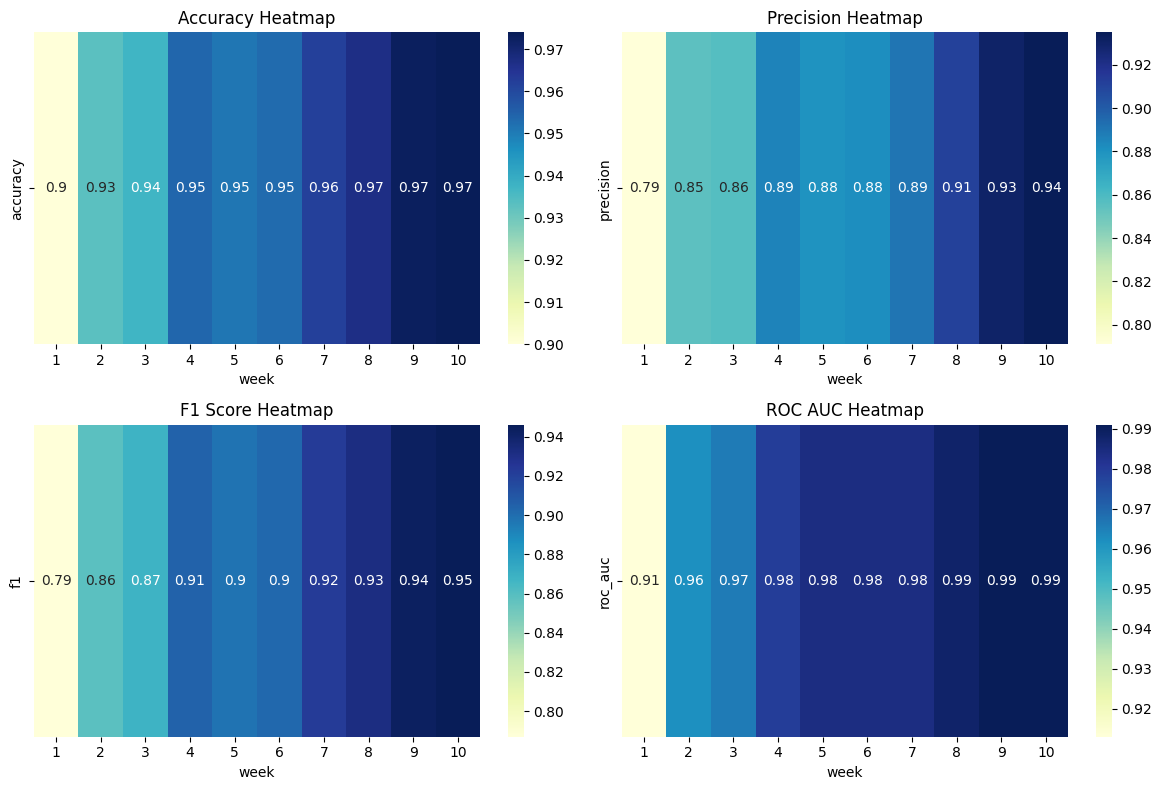

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Функция обучения модели случайного леса
def create_random_forest(X, y):
    # Создание и настройка модели случайного леса
    rf_model = RandomForestClassifier()

    # Обучение модели
    rf_model.fit(X, y)

    return rf_model  # Возвращаем модель

# Словарь для хранения моделей и списки для метрик
rf_models = {}  # Словарь для моделей
rf_metrics = []  # Список для метрик

# Создание списка для хранения предсказаний и вероятностей
rf_predictions = []
rf_probabilities = []

# Цикл от 1 до 10 для обучения моделей на обучающих данных
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из обучающей выборки
    train_week = globals()[f'train_week_{week}']
    
    # Подготовка данных для обучения
    X_week = train_week.drop(['m2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_week = train_week['m2_success']  # Целевая переменная
    
    # Обучение модели случайного леса
    rf_model = create_random_forest(X_week, y_week)

    # Сохранение модели в словарь
    rf_models[f'rf_model_week_{week}'] = rf_model  # Добавляем модель в словарь

    # Предсказания на валидационных данных
    val_week = globals()[f'val_week_{week}']
    X_val_week = val_week.drop(['m2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_val_week = val_week['m2_success']  # Целевая переменная

    predictions = rf_model.predict(X_val_week)
    predictions_proba = rf_model.predict_proba(X_val_week)[:, 1]  # Вероятности положительного класса

    # Оценка модели на валидационных данных по различным метрикам
    accuracy = accuracy_score(y_val_week, predictions)
    precision = precision_score(y_val_week, predictions)
    f1 = f1_score(y_val_week, predictions)
    roc_auc = roc_auc_score(y_val_week, predictions_proba)

    # Сохранение метрик в список
    rf_metrics.append({
        'week': week,
        'accuracy': round(accuracy, 3),
        'precision': round(precision, 3),
        'f1': round(f1, 3),
        'roc_auc': round(roc_auc, 3)
    })

    # Добавление предсказаний и вероятностей в списки
    rf_predictions.append(predictions)
    rf_probabilities.append(predictions_proba)

# Преобразование списка метрик в DataFrame
metrics_df = pd.DataFrame(rf_metrics)

# Вывод метрик для каждой недели на валидационных данных
print(metrics_df)

# Визуализация метрик с помощью тепловых карт
plt.figure(figsize=(12, 8))

# Accuracy Heatmap
plt.subplot(2, 2, 1)
sns.heatmap(metrics_df[['week', 'accuracy']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Accuracy Heatmap')

# Precision Heatmap
plt.subplot(2, 2, 2)
sns.heatmap(metrics_df[['week', 'precision']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Precision Heatmap')

# F1 Score Heatmap
plt.subplot(2, 2, 3)
sns.heatmap(metrics_df[['week', 'f1']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('F1 Score Heatmap')

# ROC AUC Heatmap
plt.subplot(2, 2, 4)
sns.heatmap(metrics_df[['week', 'roc_auc']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('ROC AUC Heatmap')

plt.tight_layout()
plt.show()

   week  accuracy  precision     f1  roc_auc
0     1     0.926      0.885  0.833    0.947
1     2     0.944      0.886  0.882    0.977
2     3     0.949      0.890  0.892    0.983
3     4     0.957      0.896  0.910    0.986
4     5     0.956      0.896  0.909    0.986
5     6     0.955      0.896  0.907    0.985
6     7     0.962      0.898  0.921    0.988
7     8     0.966      0.912  0.929    0.990
8     9     0.970      0.925  0.937    0.990
9    10     0.972      0.931  0.940    0.992


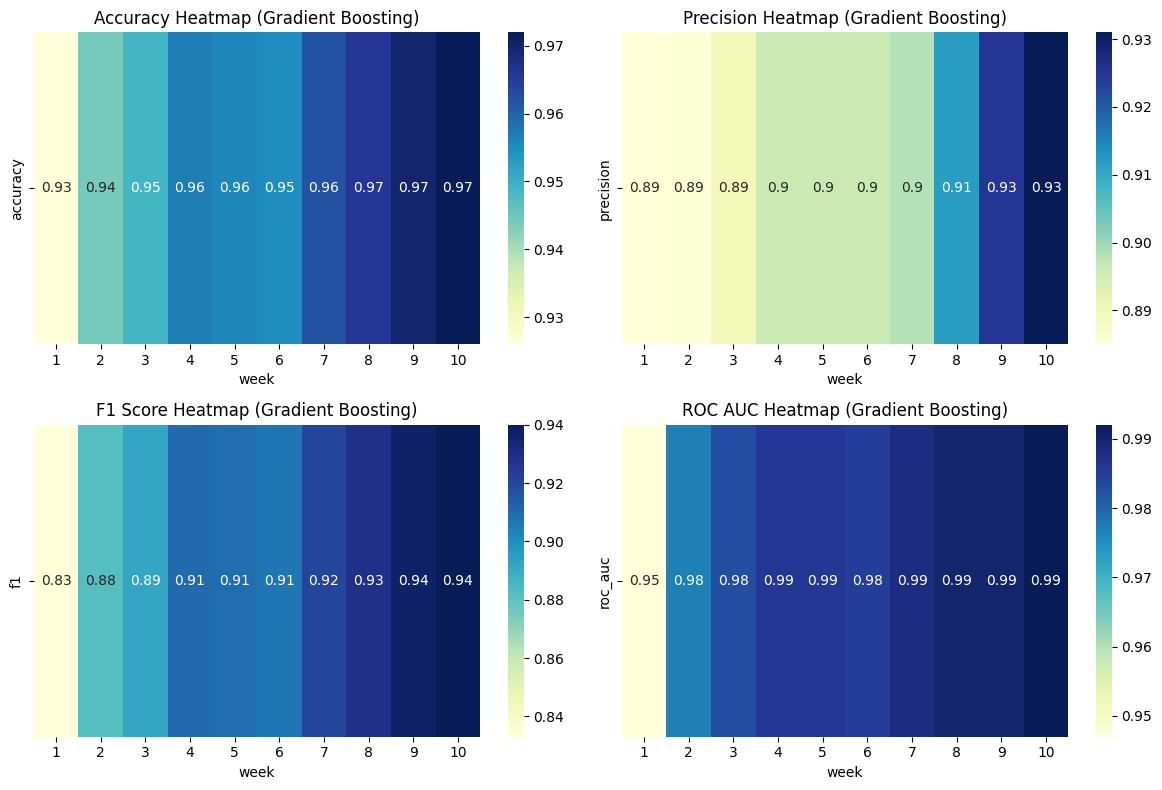

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Функция обучения модели градиентного бустинга
def create_gradient_boosting(X, y):
    # Создание и настройка модели градиентного бустинга
    gb_model = GradientBoostingClassifier()

    # Обучение модели
    gb_model.fit(X, y)

    return gb_model  # Возвращаем модель

# Словарь для хранения моделей и списки для метрик
gb_models = {}  # Словарь для моделей
gb_metrics = []  # Список для метрик

# Создание списка для хранения предсказаний и вероятностей
gb_predictions = []
gb_probabilities = []

# Цикл от 1 до 10 для обучения моделей на обучающих данных
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из обучающей выборки
    train_week = globals()[f'train_week_{week}']
    
    # Подготовка данных для обучения
    X_week = train_week.drop(['m2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_week = train_week['m2_success']  # Целевая переменная
    
    # Обучение модели градиентного бустинга
    gb_model = create_gradient_boosting(X_week, y_week)

    # Сохранение модели в словарь
    gb_models[f'gb_model_week_{week}'] = gb_model  # Добавляем модель в словарь

    # Предсказания на валидационных данных
    val_week = globals()[f'val_week_{week}']
    X_val_week = val_week.drop(['m2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_val_week = val_week['m2_success']  # Целевая переменная

    predictions = gb_model.predict(X_val_week)
    predictions_proba = gb_model.predict_proba(X_val_week)[:, 1]  # Вероятности положительного класса

    # Оценка модели на валидационных данных по различным метрикам
    accuracy = accuracy_score(y_val_week, predictions)
    precision = precision_score(y_val_week, predictions)
    f1 = f1_score(y_val_week, predictions)
    roc_auc = roc_auc_score(y_val_week, predictions_proba)

    # Сохранение метрик в список
    gb_metrics.append({
        'week': week,
        'accuracy': round(accuracy, 3),
        'precision': round(precision, 3),
        'f1': round(f1, 3),
        'roc_auc': round(roc_auc, 3)
    })

    # Добавление предсказаний и вероятностей в списки
    gb_predictions.append(predictions)
    gb_probabilities.append(predictions_proba)

# Преобразование списка метрик в DataFrame
metrics_df_gb = pd.DataFrame(gb_metrics)

# Вывод метрик для каждой недели на валидационных данных
print(metrics_df_gb)

# Визуализация метрик с помощью тепловых карт
plt.figure(figsize=(12, 8))

# Accuracy Heatmap
plt.subplot(2, 2, 1)
sns.heatmap(metrics_df_gb[['week', 'accuracy']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Accuracy Heatmap (Gradient Boosting)')

# Precision Heatmap
plt.subplot(2, 2, 2)
sns.heatmap(metrics_df_gb[['week', 'precision']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Precision Heatmap (Gradient Boosting)')

# F1 Score Heatmap
plt.subplot(2, 2, 3)
sns.heatmap(metrics_df_gb[['week', 'f1']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('F1 Score Heatmap (Gradient Boosting)')

# ROC AUC Heatmap
plt.subplot(2, 2, 4)
sns.heatmap(metrics_df_gb[['week', 'roc_auc']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('ROC AUC Heatmap (Gradient Boosting)')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

   week  accuracy  precision     f1  roc_auc
0     1     0.917      0.862  0.814    0.936
1     2     0.938      0.882  0.866    0.974
2     3     0.946      0.886  0.885    0.981
3     4     0.953      0.895  0.900    0.983
4     5     0.954      0.895  0.902    0.985
5     6     0.955      0.898  0.906    0.985
6     7     0.964      0.907  0.925    0.987
7     8     0.968      0.918  0.934    0.990
8     9     0.972      0.929  0.942    0.990
9    10     0.972      0.933  0.942    0.991


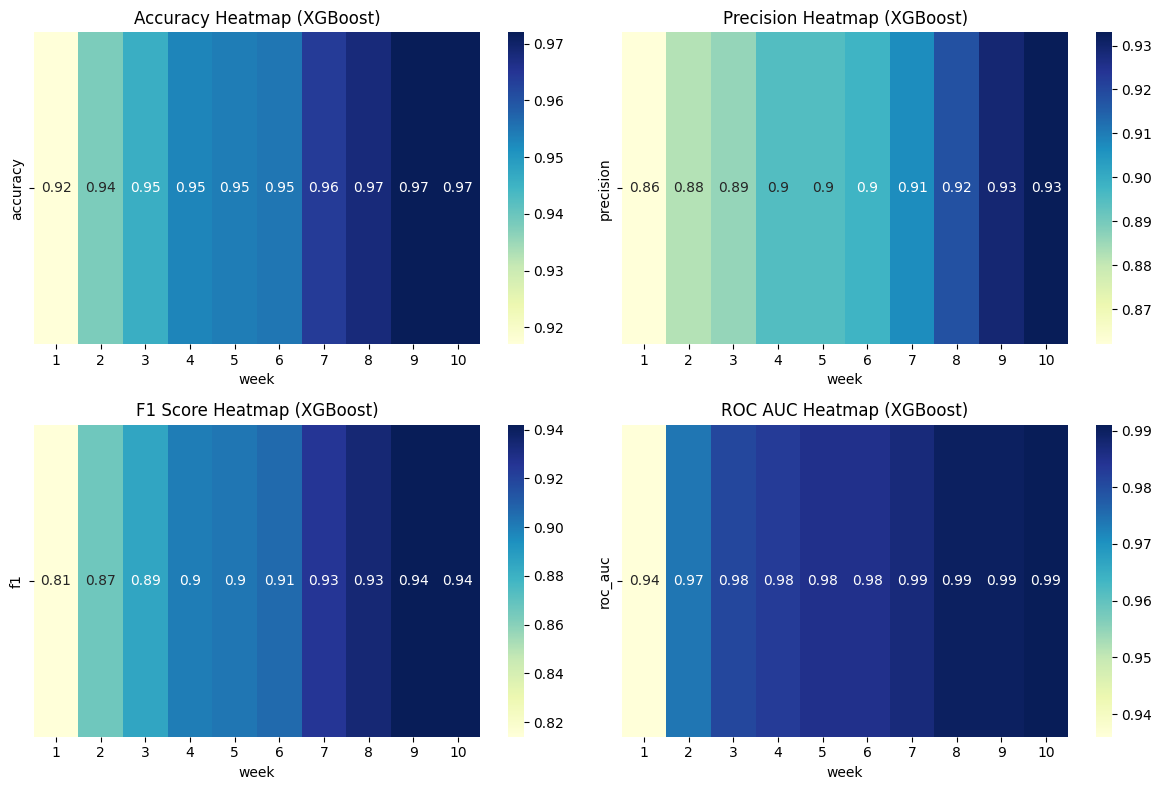

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Функция обучения модели XGBoost
def create_xgboost(X, y):
    # Создание и настройка модели XGBoost
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Обучение модели
    xgb_model.fit(X, y)

    return xgb_model  # Возвращаем модель

# Словарь для хранения моделей и списки для метрик
xgb_models = {}  # Словарь для моделей
xgb_metrics = []  # Список для метрик

# Создание списка для хранения предсказаний и вероятностей
xgb_predictions = []
xgb_probabilities = []

# Цикл от 1 до 10 для обучения моделей на обучающих данных
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из обучающей выборки
    train_week = globals()[f'train_week_{week}']
    
    # Подготовка данных для обучения
    X_week = train_week.drop(['m2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_week = train_week['m2_success']  # Целевая переменная
    
    # Обучение модели XGBoost
    xgb_model = create_xgboost(X_week, y_week)

    # Сохранение модели в словарь
    xgb_models[f'xgb_model_week_{week}'] = xgb_model  # Добавляем модель в словарь

    # Предсказания на валидационных данных
    val_week = globals()[f'val_week_{week}']
    X_val_week = val_week.drop(['m2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_val_week = val_week['m2_success']  # Целевая переменная

    predictions = xgb_model.predict(X_val_week)
    predictions_proba = xgb_model.predict_proba(X_val_week)[:, 1]  # Вероятности положительного класса

    # Оценка модели на валидационных данных по различным метрикам
    accuracy = accuracy_score(y_val_week, predictions)
    precision = precision_score(y_val_week, predictions)
    f1 = f1_score(y_val_week, predictions)
    roc_auc = roc_auc_score(y_val_week, predictions_proba)

    # Сохранение метрик в список
    xgb_metrics.append({
        'week': week,
        'accuracy': round(accuracy, 3),
        'precision': round(precision, 3),
        'f1': round(f1, 3),
        'roc_auc': round(roc_auc, 3)
    })

    # Добавление предсказаний и вероятностей в списки
    xgb_predictions.append(predictions)
    xgb_probabilities.append(predictions_proba)

# Преобразование списка метрик в DataFrame
metrics_df_xgb = pd.DataFrame(xgb_metrics)

# Вывод метрик для каждой недели на валидационных данных
print(metrics_df_xgb)

# Визуализация метрик с помощью тепловых карт
plt.figure(figsize=(12, 8))

# Accuracy Heatmap
plt.subplot(2, 2, 1)
sns.heatmap(metrics_df_xgb[['week', 'accuracy']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Accuracy Heatmap (XGBoost)')

# Precision Heatmap
plt.subplot(2, 2, 2)
sns.heatmap(metrics_df_xgb[['week', 'precision']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Precision Heatmap (XGBoost)')

# F1 Score Heatmap
plt.subplot(2, 2, 3)
sns.heatmap(metrics_df_xgb[['week', 'f1']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('F1 Score Heatmap (XGBoost)')

# ROC AUC Heatmap
plt.subplot(2, 2, 4)
sns.heatmap(metrics_df_xgb[['week', 'roc_auc']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('ROC AUC Heatmap (XGBoost)')

plt.tight_layout()
plt.show()

   week  accuracy  precision     f1  roc_auc
0     1     0.916      0.847  0.815    0.936
1     2     0.937      0.881  0.865    0.973
2     3     0.940      0.872  0.872    0.979
3     4     0.952      0.890  0.898    0.984
4     5     0.951      0.887  0.898    0.986
5     6     0.953      0.888  0.902    0.985
6     7     0.962      0.902  0.921    0.988
7     8     0.970      0.916  0.938    0.990
8     9     0.972      0.923  0.942    0.992
9    10     0.976      0.935  0.949    0.992


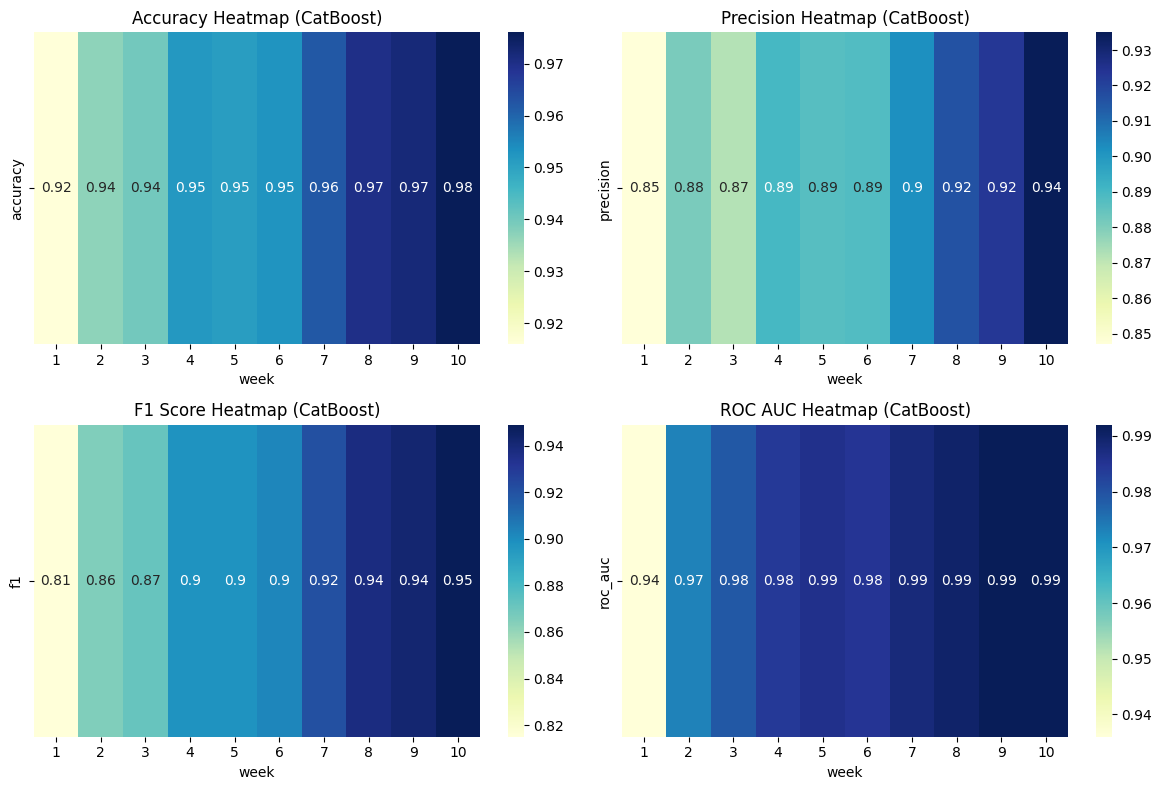

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Функция обучения модели CatBoost
def create_catboost(X, y):
    # Создание и настройка модели CatBoost
    catboost_model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        verbose=0  # Отключаем вывод во время обучения
    )

    # Обучение модели
    catboost_model.fit(X, y)

    return catboost_model  # Возвращаем модель

# Словарь для хранения моделей и списки для метрик
catboost_models = {}  # Словарь для моделей
catboost_metrics = []  # Список для метрик

# Создание списка для хранения предсказаний и вероятностей
catboost_predictions = []
catboost_probabilities = []

# Цикл от 1 до 10 для обучения моделей на обучающих данных
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из обучающей выборки
    train_week = globals()[f'train_week_{week}']
    
    # Подготовка данных для обучения
    X_week = train_week.drop(['m2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_week = train_week['m2_success']  # Целевая переменная
    
    # Обучение модели CatBoost
    catboost_model = create_catboost(X_week, y_week)

    # Сохранение модели в словарь
    catboost_models[f'catboost_model_week_{week}'] = catboost_model  # Добавляем модель в словарь

    # Предсказания на валидационных данных
    val_week = globals()[f'val_week_{week}']
    X_val_week = val_week.drop(['m2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_val_week = val_week['m2_success']  # Целевая переменная

    predictions = catboost_model.predict(X_val_week)
    predictions_proba = catboost_model.predict_proba(X_val_week)[:, 1]  # Вероятности положительного класса

    # Оценка модели на валидационных данных по различным метрикам
    accuracy = accuracy_score(y_val_week, predictions)
    precision = precision_score(y_val_week, predictions)
    f1 = f1_score(y_val_week, predictions)
    roc_auc = roc_auc_score(y_val_week, predictions_proba)

    # Сохранение метрик в список
    catboost_metrics.append({
        'week': week,
        'accuracy': round(accuracy, 3),
        'precision': round(precision, 3),
        'f1': round(f1, 3),
        'roc_auc': round(roc_auc, 3)
    })

    # Добавление предсказаний и вероятностей в списки
    catboost_predictions.append(predictions)
    catboost_probabilities.append(predictions_proba)

# Преобразование списка метрик в DataFrame
metrics_df_catboost = pd.DataFrame(catboost_metrics)

# Вывод метрик для каждой недели на валидационных данных
print(metrics_df_catboost)

# Визуализация метрик с помощью тепловых карт
plt.figure(figsize=(12, 8))

# Accuracy Heatmap
plt.subplot(2, 2, 1)
sns.heatmap(metrics_df_catboost[['week', 'accuracy']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Accuracy Heatmap (CatBoost)')

# Precision Heatmap
plt.subplot(2, 2, 2)
sns.heatmap(metrics_df_catboost[['week', 'precision']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Precision Heatmap (CatBoost)')

# F1 Score Heatmap
plt.subplot(2, 2, 3)
sns.heatmap(metrics_df_catboost[['week', 'f1']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('F1 Score Heatmap (CatBoost)')

# ROC AUC Heatmap
plt.subplot(2, 2, 4)
sns.heatmap(metrics_df_catboost[['week', 'roc_auc']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('ROC AUC Heatmap (CatBoost)')

plt.tight_layout()
plt.show()

   week  accuracy  precision     f1  roc_auc
0     1     0.921      0.887  0.820    0.864
1     2     0.939      0.898  0.865    0.940
2     3     0.944      0.901  0.877    0.949
3     4     0.945      0.901  0.881    0.973
4     5     0.952      0.910  0.897    0.985
5     6     0.954      0.906  0.903    0.986
6     7     0.961      0.914  0.917    0.988
7     8     0.966      0.918  0.929    0.989
8     9     0.973      0.937  0.944    0.992
9    10     0.975      0.938  0.947    0.992


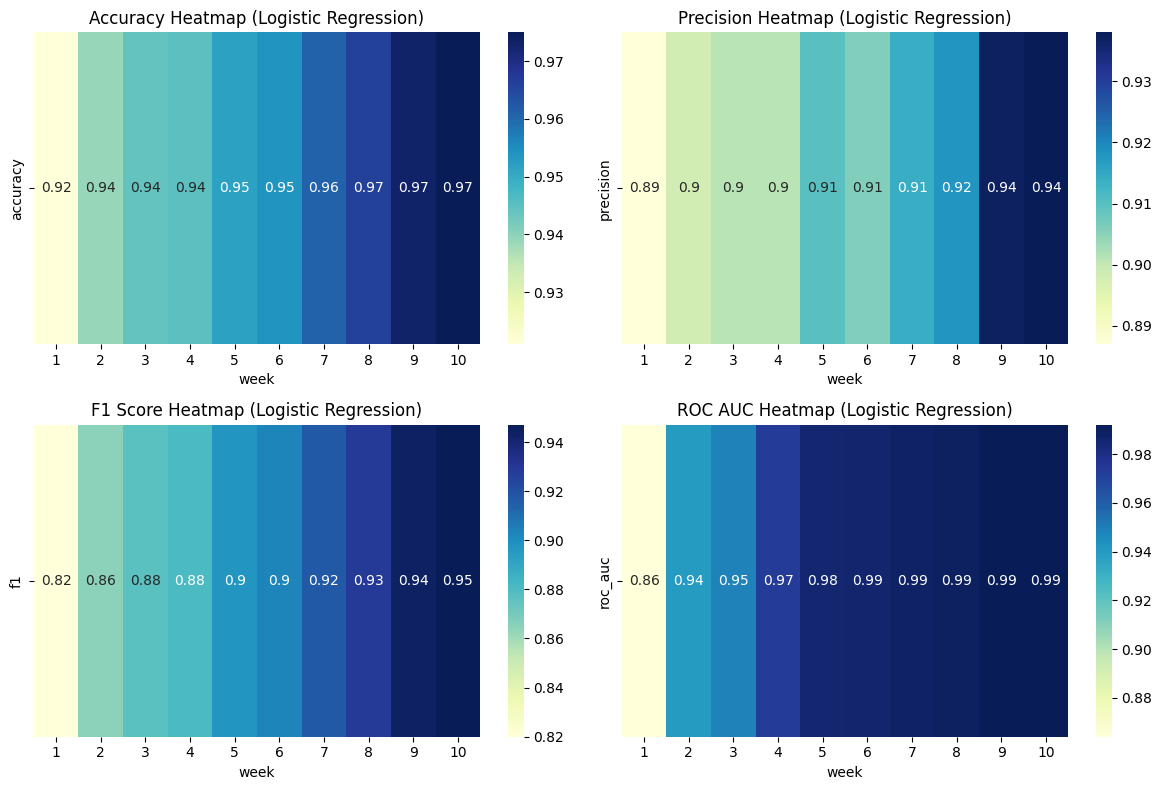

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Функция обучения модели логистической регрессии
def create_logistic_regression(X, y):
    # Создание и настройка модели логистической регрессии
    lr_model = LogisticRegression(max_iter=1000)

    # Обучение модели
    lr_model.fit(X, y)

    return lr_model  # Возвращаем модель

# Словарь для хранения моделей и списки для метрик
lr_models = {}  # Словарь для моделей
lr_metrics = []  # Список для метрик

# Создание списка для хранения предсказаний и вероятностей
lr_predictions = []
lr_probabilities = []

# Цикл от 1 до 10 для обучения моделей на обучающих данных
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из обучающей выборки
    train_week = globals()[f'train_week_{week}']
    
    # Подготовка данных для обучения
    X_week = train_week.drop(['m2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_week = train_week['m2_success']  # Целевая переменная
    
    # Обучение модели логистической регрессии
    lr_model = create_logistic_regression(X_week, y_week)

    # Сохранение модели в словарь
    lr_models[f'lr_model_week_{week}'] = lr_model  # Добавляем модель в словарь

    # Предсказания на валидационных данных
    val_week = globals()[f'val_week_{week}']
    X_val_week = val_week.drop(['m2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_val_week = val_week['m2_success']  # Целевая переменная

    predictions = lr_model.predict(X_val_week)
    predictions_proba = lr_model.predict_proba(X_val_week)[:, 1]  # Вероятности положительного класса

    # Оценка модели на валидационных данных по различным метрикам
    accuracy = accuracy_score(y_val_week, predictions)
    precision = precision_score(y_val_week, predictions)
    f1 = f1_score(y_val_week, predictions)
    roc_auc = roc_auc_score(y_val_week, predictions_proba)

    # Сохранение метрик в список
    lr_metrics.append({
        'week': week,
        'accuracy': round(accuracy, 3),
        'precision': round(precision, 3),
        'f1': round(f1, 3),
        'roc_auc': round(roc_auc, 3)
    })

    # Добавление предсказаний и вероятностей в списки
    lr_predictions.append(predictions)
    lr_probabilities.append(predictions_proba)

# Преобразование списка метрик в DataFrame
metrics_df_lr = pd.DataFrame(lr_metrics)

# Вывод метрик для каждой недели на валидационных данных
print(metrics_df_lr)

# Визуализация метрик с помощью тепловых карт
plt.figure(figsize=(12, 8))

# Accuracy Heatmap
plt.subplot(2, 2, 1)
sns.heatmap(metrics_df_lr[['week', 'accuracy']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Accuracy Heatmap (Logistic Regression)')

# Precision Heatmap
plt.subplot(2, 2, 2)
sns.heatmap(metrics_df_lr[['week', 'precision']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Precision Heatmap (Logistic Regression)')

# F1 Score Heatmap
plt.subplot(2, 2, 3)
sns.heatmap(metrics_df_lr[['week', 'f1']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('F1 Score Heatmap (Logistic Regression)')

# ROC AUC Heatmap
plt.subplot(2, 2, 4)
sns.heatmap(metrics_df_lr[['week', 'roc_auc']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('ROC AUC Heatmap (Logistic Regression)')

plt.tight_layout()
plt.show()

   week  accuracy  precision     f1  roc_auc
0     1     0.923      0.878  0.828    0.939
1     2     0.935      0.874  0.860    0.975
2     3     0.944      0.880  0.882    0.981
3     4     0.952      0.893  0.899    0.985
4     5     0.953      0.893  0.902    0.982
5     6     0.955      0.895  0.905    0.982
6     7     0.963      0.900  0.924    0.987
7     8     0.969      0.918  0.936    0.990
8     9     0.971      0.921  0.940    0.990
9    10     0.972      0.927  0.941    0.991


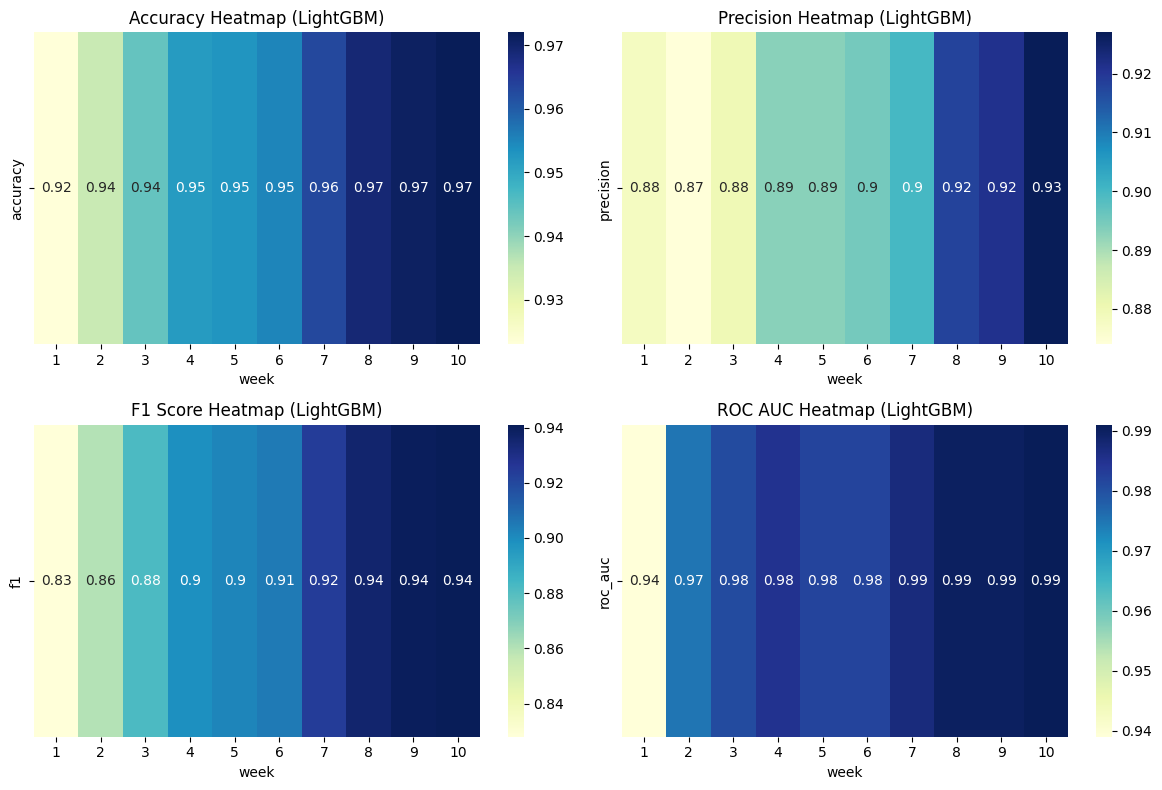

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Функция обучения модели LightGBM
def create_lightgbm(X, y):
    # Создание и настройка модели LightGBM
    lgbm_model = LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        num_leaves=31,
        verbose=0  # Отключаем вывод во время обучения
    )

    # Обучение модели
    lgbm_model.fit(X, y)

    return lgbm_model  # Возвращаем модель

# Словарь для хранения моделей и списки для метрик
lgbm_models = {}  # Словарь для моделей
lgbm_metrics = []  # Список для метрик

# Создание списка для хранения предсказаний и вероятностей
lgbm_predictions = []
lgbm_probabilities = []

# Цикл от 1 до 10 для обучения моделей на обучающих данных
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из обучающей выборки
    train_week = globals()[f'train_week_{week}']
    
    # Подготовка данных для обучения
    X_week = train_week.drop(['m2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_week = train_week['m2_success']  # Целевая переменная
    
    # Обучение модели LightGBM
    lgbm_model = create_lightgbm(X_week, y_week)

    # Сохранение модели в словарь
    lgbm_models[f'lgbm_model_week_{week}'] = lgbm_model  # Добавляем модель в словарь

    # Предсказания на валидационных данных
    val_week = globals()[f'val_week_{week}']
    X_val_week = val_week.drop(['m2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_val_week = val_week['m2_success']  # Целевая переменная

    predictions = lgbm_model.predict(X_val_week)
    predictions_proba = lgbm_model.predict_proba(X_val_week)[:, 1]  # Вероятности положительного класса

    # Оценка модели на валидационных данных по различным метрикам
    accuracy = accuracy_score(y_val_week, predictions)
    precision = precision_score(y_val_week, predictions)
    f1 = f1_score(y_val_week, predictions)
    roc_auc = roc_auc_score(y_val_week, predictions_proba)

    # Сохранение метрик в список
    lgbm_metrics.append({
        'week': week,
        'accuracy': round(accuracy, 3),
        'precision': round(precision, 3),
        'f1': round(f1, 3),
        'roc_auc': round(roc_auc, 3)
    })

    # Добавление предсказаний и вероятностей в списки
    lgbm_predictions.append(predictions)
    lgbm_probabilities.append(predictions_proba)

# Преобразование списка метрик в DataFrame
metrics_df_lgbm = pd.DataFrame(lgbm_metrics)

# Вывод метрик для каждой недели на валидационных данных
print(metrics_df_lgbm)

# Визуализация метрик с помощью тепловых карт
plt.figure(figsize=(12, 8))

# Accuracy Heatmap
plt.subplot(2, 2, 1)
sns.heatmap(metrics_df_lgbm[['week', 'accuracy']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Accuracy Heatmap (LightGBM)')

# Precision Heatmap
plt.subplot(2, 2, 2)
sns.heatmap(metrics_df_lgbm[['week', 'precision']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Precision Heatmap (LightGBM)')

# F1 Score Heatmap
plt.subplot(2, 2, 3)
sns.heatmap(metrics_df_lgbm[['week', 'f1']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('F1 Score Heatmap (LightGBM)')

# ROC AUC Heatmap
plt.subplot(2, 2, 4)
sns.heatmap(metrics_df_lgbm[['week', 'roc_auc']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('ROC AUC Heatmap (LightGBM)')

plt.tight_layout()
plt.show()

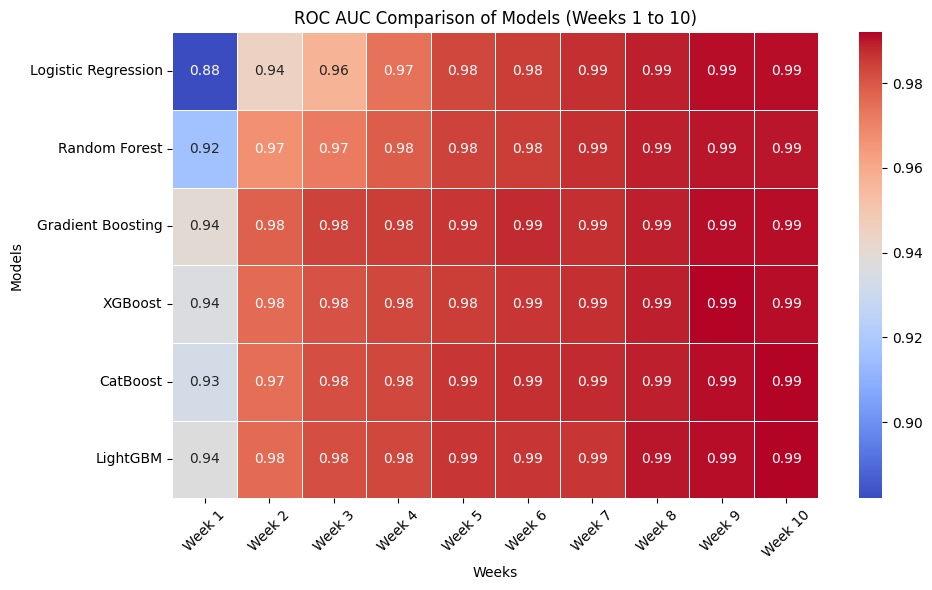

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Предполагаем, что у вас уже есть метрики для всех моделей, сохраненные в переменных:
# lr_metrics, rf_metrics, gb_metrics, xgb_metrics, catboost_metrics, lgbm_metrics

# Создание списка для ROC AUC значений
roc_auc_data = {
    'Logistic Regression': [metric['roc_auc'] for metric in lr_metrics],
    'Random Forest': [metric['roc_auc'] for metric in rf_metrics],
    'Gradient Boosting': [metric['roc_auc'] for metric in gb_metrics],
    'XGBoost': [metric['roc_auc'] for metric in xgb_metrics],
    'CatBoost': [metric['roc_auc'] for metric in catboost_metrics],
    'LightGBM': [metric['roc_auc'] for metric in lgbm_metrics]
}

# Создание DataFrame из собранных данных
roc_auc_df = pd.DataFrame(roc_auc_data, index=[f'Week {i}' for i in range(1, 11)])

# Транспонирование DataFrame
roc_auc_df_t = roc_auc_df.transpose()

# Визуализация ROC AUC с помощью тепловой карты
plt.figure(figsize=(10, 6))
sns.heatmap(roc_auc_df_t, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('ROC AUC Comparison of Models (Weeks 1 to 10)')
plt.xlabel('Weeks')
plt.ylabel('Models')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('./outputs/roc-auc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

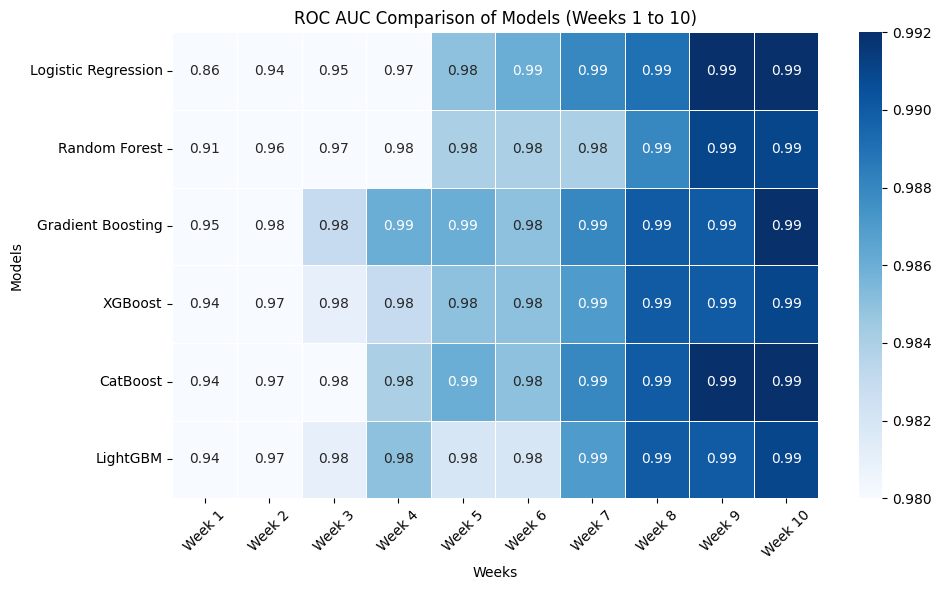

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Предполагаем, что у вас уже есть метрики для всех моделей, сохраненные в переменных:
# lr_metrics, rf_metrics, gb_metrics, xgb_metrics, catboost_metrics, lgbm_metrics

# Создание списка для ROC AUC значений
roc_auc_data = {
    'Logistic Regression': [metric['roc_auc'] for metric in lr_metrics],
    'Random Forest': [metric['roc_auc'] for metric in rf_metrics],
    'Gradient Boosting': [metric['roc_auc'] for metric in gb_metrics],
    'XGBoost': [metric['roc_auc'] for metric in xgb_metrics],
    'CatBoost': [metric['roc_auc'] for metric in catboost_metrics],
    'LightGBM': [metric['roc_auc'] for metric in lgbm_metrics]
}

# Создание DataFrame из собранных данных
roc_auc_df = pd.DataFrame(roc_auc_data, index=[f'Week {i}' for i in range(1, 11)])

# Транспонирование DataFrame
roc_auc_df_t = roc_auc_df.transpose()

# Визуализация ROC AUC с помощью тепловой карты
plt.figure(figsize=(10, 6))
sns.heatmap(roc_auc_df_t, annot=True, cmap='Blues', cbar=True, linewidths=0.5,
            vmin=0.98, vmax=0.992)  # Установка минимального и максимального порога для визуализации
plt.title('ROC AUC Comparison of Models (Weeks 1 to 10)')
plt.xlabel('Weeks')
plt.ylabel('Models')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('./outputs/roc-auc_comparison_blues.png', dpi=300, bbox_inches='tight')
plt.show()